In [3]:
pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.6 MB/s eta 0:00:00


# Creando la red neuronal y convertir el dataset

In [4]:
from Bio.SeqUtils import ProtParam
import pandas as pd
import urllib.request
from io import StringIO
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import confusion_matrix, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# URL of the CSV file
url = "https://raw.githubusercontent.com/raulivan1200/hiv/main/hiv%20dataset.csv"

try:
    # Read data from the URL
    response = urllib.request.urlopen(url)
    data = response.read().decode('utf-8')
    df = pd.read_csv(StringIO(data))

    # Function to calculate and print protein qualities using ProtParam
    def calculate_protein_properties(sequence):
        try:
            # Create a ProtParam object with the protein sequence
            protein_param = ProtParam.ProteinAnalysis(sequence)

            # Print Molecular Weight
            print(f'Molecular Weight: {protein_param.molecular_weight()}')

            # Print Theoretical PI
            print(f'Theoretical PI: {protein_param.isoelectric_point()}')

            # Print Amino Acid Composition
            print(f'Amino Acid Composition: {protein_param.get_amino_acids_percent()}')

            # Print Atomic Composition
            print(f'Atomic Composition (C, H, N, O, S): {protein_param.get_amino_acids_percent()}')

        except Exception as e:
            print(f"Error calculating properties for sequence: {sequence}. Error: {e}")

    # Iterate through rows and calculate properties for each protein
    for index, row in df.iterrows():
        print(f'\nProtein at index {index + 1}:')
        sequence = row['sequence']
        calculate_protein_properties(sequence)

    # Tokenization
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(df['sequence'])

    # Convert sequences to sequences of numbers
    sequences = tokenizer.texts_to_sequences(df['sequence'])

    # Padding for equal sequence length
    padded_sequences = pad_sequences(sequences)

    # Define input features and labels
    input_features = np.expand_dims(padded_sequences, axis=-1)  # Add a channel dimension
    input_labels = pd.get_dummies(df['label']).values  # one-hot encoding for labels

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(
        input_features, input_labels, test_size=0.25, random_state=42)

    # Adjust the output layer for multi-class classification
    num_classes = len(df['label'].unique())
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=12, input_shape=(input_features.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Adjust the output layer

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    # Train the model
    history = model.fit(train_features, train_labels, epochs=50, verbose=0, validation_split=0.25)

except urllib.error.URLError:
    print(f"Failed to connect to the URL: {url}")

except pd.errors.EmptyDataError:
    print(f"CSV file is empty or has no data.")

except pd.errors.ParserError:
    print(f"Error parsing CSV file. Please check the file format.")

except Exception as ex:
    print(f"An unexpected error occurred: {ex}")

Streaming output truncated to the last 5000 lines.

Protein at index 8546:
Molecular Weight: 3745.236900000001
Theoretical PI: 9.8444673538208
Amino Acid Composition: {'A': 0.058823529411764705, 'C': 0.058823529411764705, 'D': 0.029411764705882353, 'E': 0.0, 'F': 0.029411764705882353, 'G': 0.11764705882352941, 'H': 0.058823529411764705, 'I': 0.08823529411764706, 'K': 0.058823529411764705, 'L': 0.0, 'M': 0.029411764705882353, 'N': 0.08823529411764706, 'P': 0.058823529411764705, 'Q': 0.029411764705882353, 'R': 0.08823529411764706, 'S': 0.029411764705882353, 'T': 0.11764705882352941, 'V': 0.029411764705882353, 'W': 0.0, 'Y': 0.029411764705882353}
Atomic Composition (C, H, N, O, S): {'A': 0.058823529411764705, 'C': 0.058823529411764705, 'D': 0.029411764705882353, 'E': 0.0, 'F': 0.029411764705882353, 'G': 0.11764705882352941, 'H': 0.058823529411764705, 'I': 0.08823529411764706, 'K': 0.058823529411764705, 'L': 0.0, 'M': 0.029411764705882353, 'N': 0.08823529411764706, 'P': 0.05882352941176470

# Mostrando la presición de nuestro dataset y la matriz de confusion

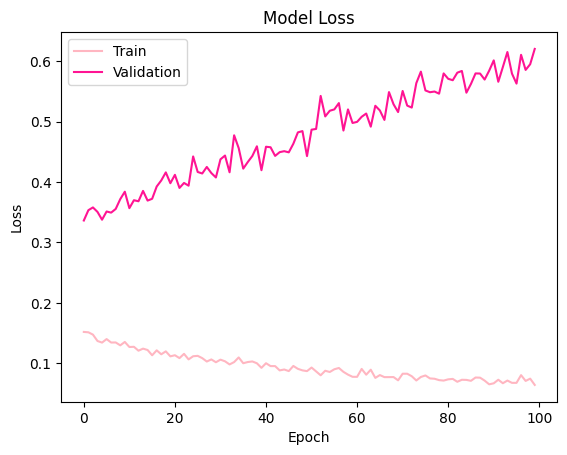

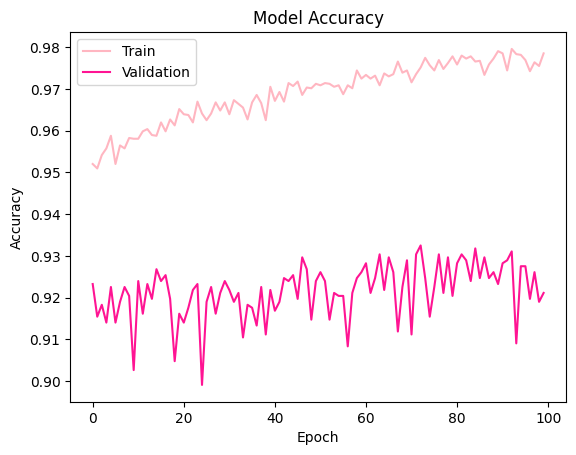

74/74 [==============================] - 0s 2ms/step
Weighted Precision: 0.9235901171853401


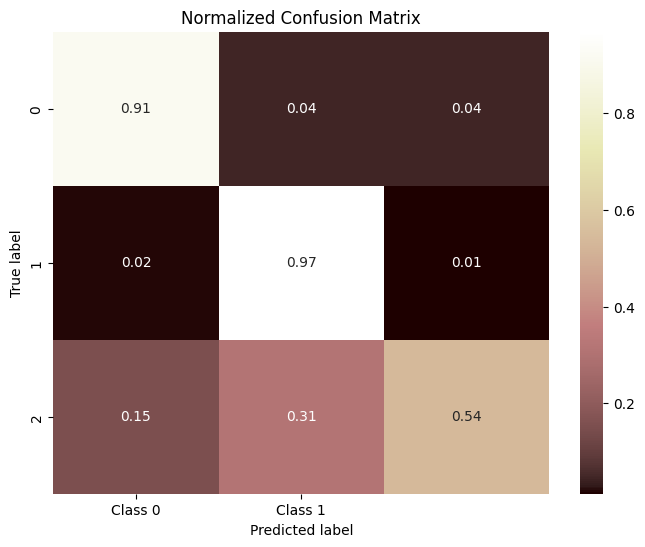

In [5]:
# Importing the necessary libraries
from sklearn.metrics import confusion_matrix, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model
history = model.fit(train_features, train_labels, epochs=100, verbose=0, validation_split=0.20)

# Plot loss with a pink color palette
plt.figure()
plt.plot(history.history['loss'], color='lightpink')
plt.plot(history.history['val_loss'], color='deeppink')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot accuracy with a pink color palette
plt.figure()
plt.plot(history.history['accuracy'], color='lightpink')
plt.plot(history.history['val_accuracy'], color='deeppink')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# Predict labels for the test set
predicted_labels = model.predict(test_features)

# Convert one-hot encoded labels back to integers
true_labels = np.argmax(test_labels, axis=1)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print(f'Weighted Precision: {precision}')

# Plot confusion matrix with a pink color palette
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='pink', fmt=".2f", xticklabels=['Class 0', 'Class 1'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()